In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import glob
import os
import datetime,time
import torch.nn as nn
import torchvision.datasets as dsets
import pandas as pd
from torchvision.io import read_image
import numpy as np
from torch.utils.tensorboard import SummaryWriter


In [5]:
#to unzip datasets
import zipfile

#visualize some datasets
import matplotlib.pyplot as plt

writer = SummaryWriter()

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
os.listdir('../examples/dogs-vs-cats-redux-kernels-edition')

['sample_submission.csv', 'train.zip', 'test.zip']

In [8]:
os.makedirs('../data', exist_ok =True)

In [9]:
base_dir = '../examples/dogs-vs-cats-redux-kernels-edition'
train_dir = '../data/train'
test_dir = '../data/test'

In [10]:
with zipfile.ZipFile(os.path.join(base_dir, 'train.zip')) as train_zip:
    train_zip.extractall('../data')
    
with zipfile.ZipFile(os.path.join(base_dir, 'test.zip')) as test_zip:
    test_zip.extractall('../data')

In [11]:
os.listdir(train_dir)[:5]

['dog.8615.jpg',
 'cat.11873.jpg',
 'dog.6856.jpg',
 'dog.1905.jpg',
 'cat.6599.jpg']

In [12]:
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [13]:
len(train_list)

25000

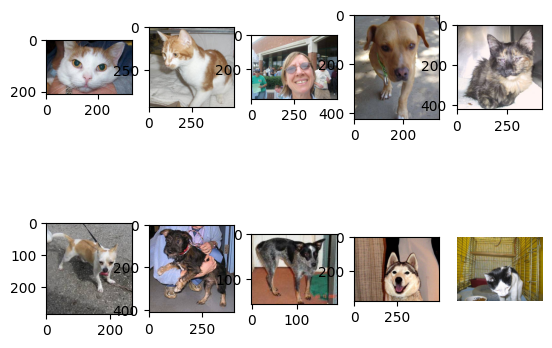

In [14]:
from PIL import Image
random_idx = np.random.randint(1,25000,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [15]:
train_list[0].split('/')[-1].split('.')[0]

'dog'

In [16]:
int(test_list[0].split('/')[-1].split('.')[0])

6293

In [17]:
print(len(train_list), len(test_list))

25000 12500


In [18]:
from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(train_list, test_size=0.2)

In [19]:
#data Augumentation
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])


test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
     transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [20]:
class dataset(torch.utils.data.Dataset):
    #가져와서 처리
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label
        

In [21]:
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=test_transforms)

In [22]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

In [23]:
print(len(train_data), len(train_loader))

20000 313


In [24]:
print(len(val_data), len(val_loader))

5000 79


In [25]:
#check our images shape
train_data[0][0].shape

torch.Size([3, 224, 224])

In [26]:
os.getcwd()

'/home/ram/vit-pytorch/examples'

In [27]:
from vit import ViT

model = ViT(
    image_size = 224,
    patch_size = 32,
    num_classes = 2,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

In [28]:
model.to(device)
# model.train()

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
    (1): Linear(in_features=3072, out_features=1024, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.1, inplace=False)
            (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=1024, out_features=1024, bias=True)
              (1): Dropout(p=0.1, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=1024, out_feature

In [29]:
learning_rate = 3e-5  #learning rate

num_epochs = 20  

# gamma = 0.7
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# import torch.optim.lr_scheduler.StepLR
# scheduler
# scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

total_step = len(train_loader)
print("Total step: ",total_step)

Total step:  313


In [30]:

for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        
        output = model(data)
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        acc = ((output.argmax(dim=1) == label).float().mean())
        epoch_accuracy += acc/len(train_loader)
        epoch_loss += loss/len(train_loader)
        
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
    
    
    with torch.no_grad():
        epoch_val_accuracy=0
        epoch_val_loss =0
        for data, label in val_loader:
            data = data.to(device)
            label = label.to(device)
            
            val_output = model(data)
            val_loss = criterion(val_output,label)
            
            
            acc = ((val_output.argmax(dim=1) == label).float().mean())
            epoch_val_accuracy += acc/ len(val_loader)
            epoch_val_loss += val_loss/ len(val_loader)
            
        print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))

Epoch : 1, train accuracy : 0.5127788186073303, train loss : 0.712752640247345
Epoch : 1, val_accuracy : 0.5284810662269592, val_loss : 0.6896683573722839
Epoch : 2, train accuracy : 0.547224223613739, train loss : 0.6917093396186829
Epoch : 2, val_accuracy : 0.5591376423835754, val_loss : 0.6843349933624268
Epoch : 3, train accuracy : 0.5686401724815369, train loss : 0.6802713871002197
Epoch : 3, val_accuracy : 0.577333927154541, val_loss : 0.6749920845031738
Epoch : 4, train accuracy : 0.5746307373046875, train loss : 0.6793023347854614
Epoch : 4, val_accuracy : 0.5628955960273743, val_loss : 0.6820919513702393
Epoch : 5, train accuracy : 0.5763281583786011, train loss : 0.673629879951477
Epoch : 5, val_accuracy : 0.5953322649002075, val_loss : 0.6691712141036987
Epoch : 6, train accuracy : 0.5910544395446777, train loss : 0.6653980612754822
Epoch : 6, val_accuracy : 0.6052215695381165, val_loss : 0.6608401536941528
Epoch : 7, train accuracy : 0.6117210984230042, train loss : 0.65244

In [31]:
# dog_probs = []
# model.eval()
# with torch.no_grad():
#     for data, fileid in test_loader:
#         data = data.to(device)
#         preds = model(data)
#         preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
#         dog_probs += list(zip(list(fileid), preds_list))